# Predicting Daily Bitcoin Stock

In this lab, we'll be working with a dataset from Kaggle that contains time series data for Bitcoin and other digital currencies. This data was prepared using the Alpha Vantage API and is well-suited for exploring time-based modeling.

**Dataset Download:**  
[Digital Currency Time Series (Kaggle)](https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series?resource=download)


## Primary Goal

- Predict daily Bitcoin stock using time series data.


## Assignment Specifications

- You must explore multiple **Recurrent Neural Network (RNN)** models to solve this prediction problem.
- The dataset includes multiple time series. You may choose which one you want to focus on (e.g., Bitcoin, Ethereum).
- Your submission should be written for a **non-expert audience**:
  - Narrate your code and decisions using accessible language.
  - Avoid technical jargon unless it is clearly explained.
- Include all relevant code, but prioritize clarity and communication in your notebook.
- Submit your final work as either:
  - An HTML file  
  - A Jupyter Notebook (`.ipynb`)  
  - A link to a Colab notebook
- **Before submitting**, make sure to restart your kernel and rerun all cells to ensure your outputs are up to date.


Be thorough, be clear, and have fun with your modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
import random
import os

def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Dataset Introduction

The dataset used in this analysis contains historical time series data for various digital currencies, including Bitcoin, sourced via the Alpha Vantage API and made available on Kaggle. Each record includes daily trading metrics such as open, high, low, close prices, trading volume, and market capitalization for each currency, identified by timestamps.



In [ ]:
url = "https://raw.githubusercontent.com/bellamccarty/GSB-545/refs/heads/main/Lab05/Data/dc.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [ ]:
# Quick overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1000 non-null   object 
 1   open_SAR    1000 non-null   float64
 2   open_USD    1000 non-null   float64
 3   high_SAR    1000 non-null   float64
 4   high_USD    1000 non-null   float64
 5   low_SAR     1000 non-null   float64
 6   low_USD     1000 non-null   float64
 7   close_SAR   1000 non-null   float64
 8   close_USD   1000 non-null   float64
 9   volume      1000 non-null   int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 78.3+ KB


,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


### Clean Column Names and Parse Dates

The first column appears to be a timestamp. We'll rename it to `date` and convert it to datetime format to facilitate our time series operations.

In [ ]:
# Rename and convert date column
df = df.rename(columns={"Unnamed: 0": "date"})
df["date"] = pd.to_datetime(df["date"])

# Sort by date (important for time series)
df = df.sort_values("date").reset_index(drop=True)

### Plot Bitcoin Price Trends Over Time

We'll visualize the USD prices over time: open, high, low, and close. This gives us a sense of volatility, trends, and potential stationarity issues.

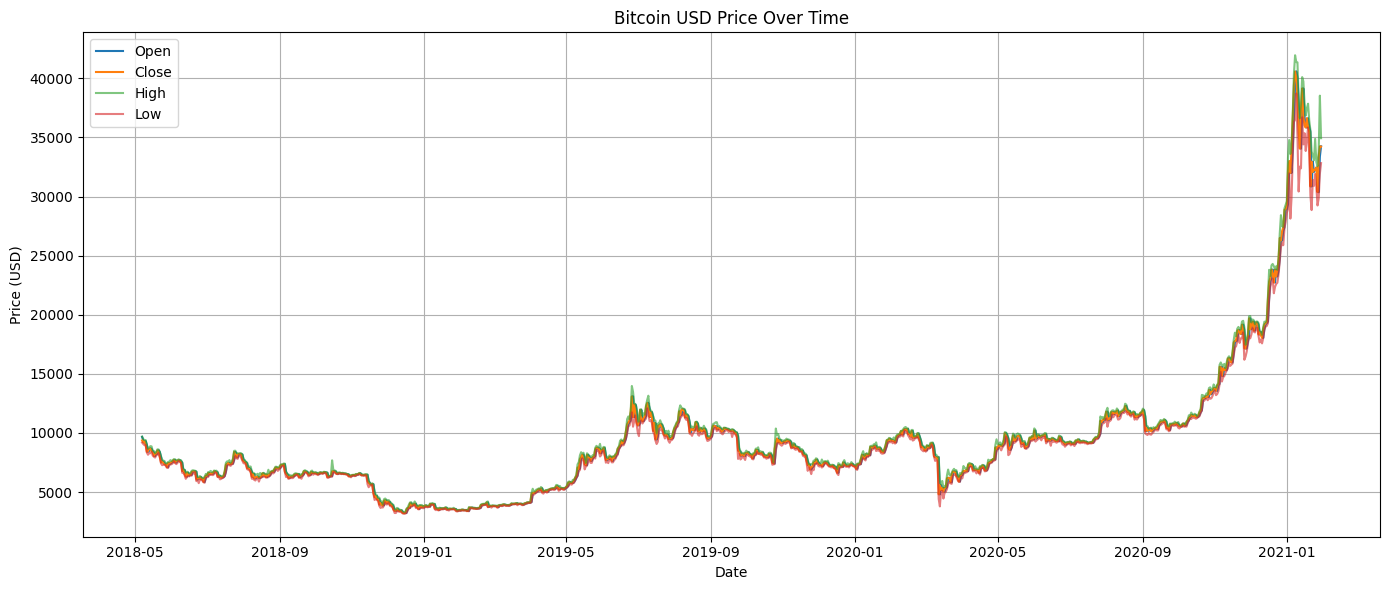

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["open_USD"], label="Open")
plt.plot(df["date"], df["close_USD"], label="Close")
plt.plot(df["date"], df["high_USD"], label="High", alpha=0.6)
plt.plot(df["date"], df["low_USD"], label="Low", alpha=0.6)
plt.title("Bitcoin USD Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Explore Volume Over Time

Volume can be an important indicator in financial modeling. We'll plot it to see if there are any patterns or anomalies.

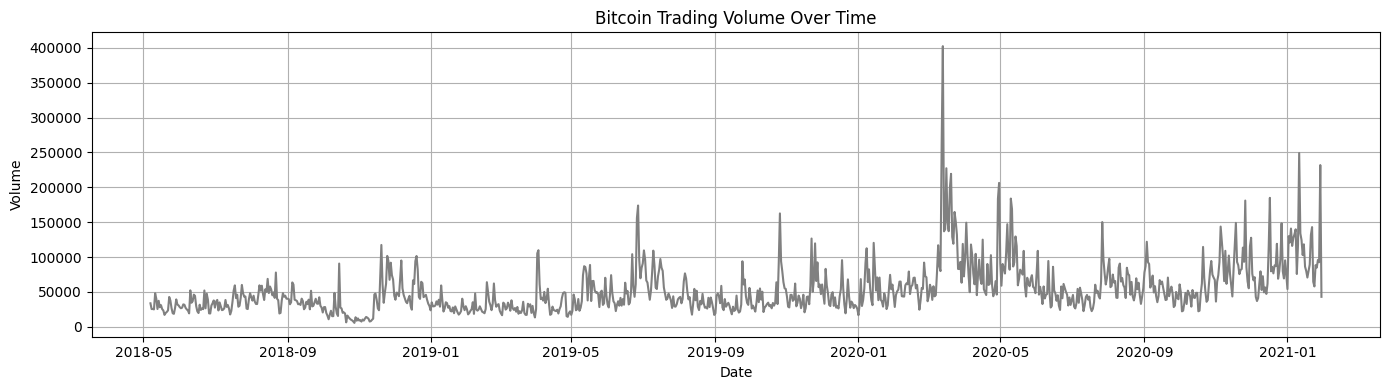

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(df["date"], df["volume"], color="gray")
plt.title("Bitcoin Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Price Trends

- Bitcoin prices were relatively stable and low between 2018 and early 2020.
- A noticeable upward trend began in mid-2020, culminating in a sharp surge during late 2020 and early 2021, with Bitcoin surpassing $40,000.
- The high correlation between the open, close, high, and low values indicates relatively consistent daily movement ranges without large intraday anomalies.

#### Volume Trends

- Trading volume fluctuated heavily over the time period, with several extreme spikes (notably around early 2020).
- Volume generally increased during periods of rising prices, particularly during the 2020 bull market. This supports the idea that price and volume are often positively correlated in speculative markets like cryptocurrency.

## Model Prep

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def scale_series(series):
    """
    Scales a single-column DataFrame using MinMaxScaler.

    Returns the scaled array and the fitted scaler.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    return scaled, scaler

def split_time_series(data, train_ratio=0.8):
    """
    Splits time series array into train/test sets.
    """
    train_size = int(len(data) * train_ratio)
    train = data[:train_size]
    test = data[train_size:]
    return train, test

def create_dataset(dataset, look_back=1):
    """
    Creates sequences of lagged inputs and next-step targets.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def reshape_for_rnn(X):
    """
    Reshapes array to fit RNN/LSTM input: (samples, timesteps, features)
    """
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
# Select and scale the target variable
btc = df[["close_USD"]]
btc_scaled, btc_scaler = scale_series(btc)

# Split
train, test = split_time_series(btc_scaled, train_ratio=0.8)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

def build_rnn_model(input_shape, units=50, dropout=0.2, seed=42):
    """
    Builds a SimpleRNN model with specified units and dropout.
    """
    model = Sequential([
        SimpleRNN(units, activation='tanh',
                  input_shape=input_shape,
                  kernel_initializer=GlorotUniform(seed=seed)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_shape, units=50, dropout=0.2, seed=42):
    """
    Builds an LSTM model with specified units and dropout.
    """
    model = Sequential([
        LSTM(units, activation='tanh',
             input_shape=input_shape,
             kernel_initializer=GlorotUniform(seed=seed)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


def run_grid_search(train, test, param_grid, build_model_fn, model_name="LSTM"):
    """
    Performs a grid search over look_back, units, and dropout for a given model builder.

    Parameters:
        - train, test: np.array of scaled data
        - param_grid: dict with keys 'look_back', 'units', 'dropout'
        - build_model_fn: function that returns a compiled Keras model
        - model_name: string identifier to label the results ('LSTM' or 'RNN')

    Returns:
        - results_df: DataFrame with all combinations and their validation MSE
    """
    results = []

    for look_back in param_grid['look_back']:
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = reshape_for_rnn(trainX)
        testX = reshape_for_rnn(testX)

        for units in param_grid['units']:
            for dropout in param_grid['dropout']:
                model = build_model_fn((look_back, 1), units=units, dropout=dropout)

                history = model.fit(
                    trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
                )

                preds = model.predict(testX, verbose=0)
                mse = mean_squared_error(testY, preds)

                results.append({
                    'model': model_name,
                    'look_back': look_back,
                    'units': units,
                    'dropout': dropout,
                    'val_mse': mse
                })

    return pd.DataFrame(results).sort_values(by="val_mse")

## LSTM

In [ ]:
set_seeds(42)

param_grid = {
    'look_back': [10, 20, 30],
    'units': [50, 64],
    'dropout': [0.2, 0.3]
}

lstm_results_df = run_grid_search(train, test, param_grid, build_model_fn=build_lstm_model, model_name="LSTM")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

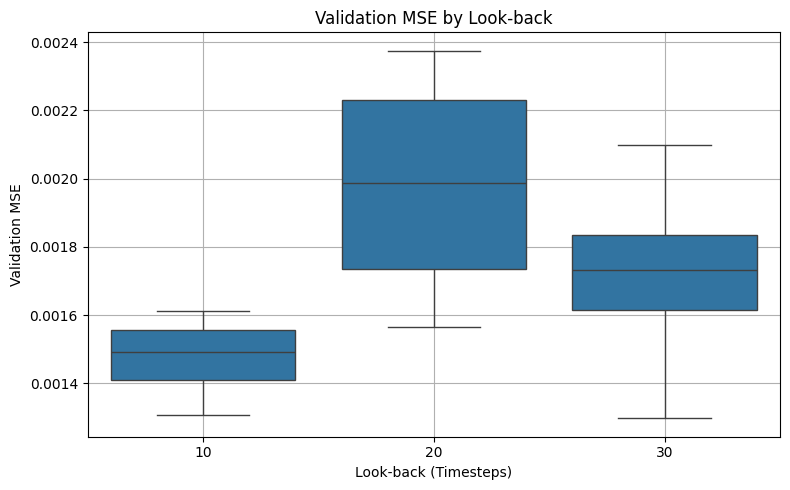

In [ ]:
lstm_results_df = lstm_results_df.sort_values(by="val_mse")

plt.figure(figsize=(8, 5))
sns.boxplot(data=lstm_results_df, x='look_back', y='val_mse')
plt.title("Validation MSE by Look-back")
plt.xlabel("Look-back (Timesteps)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

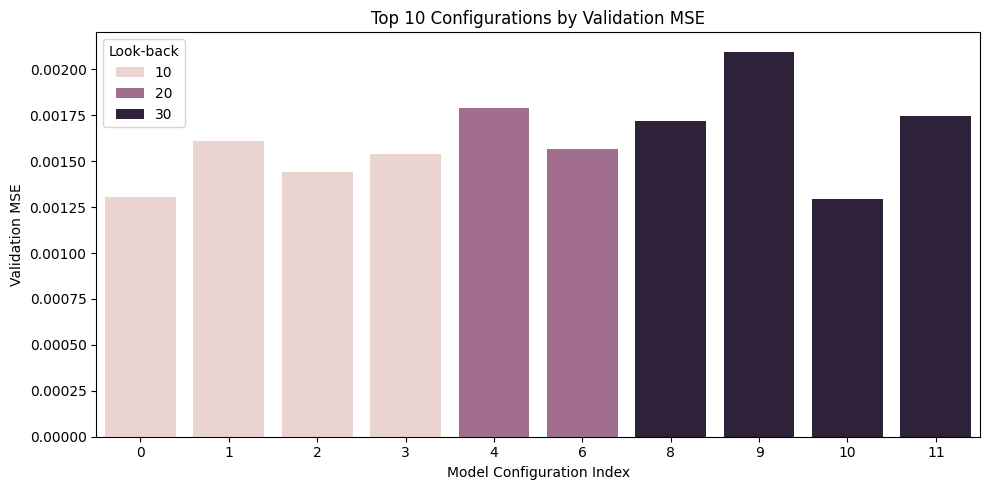

In [ ]:
top10 = lstm_results_df.sort_values("val_mse").head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x=top10.index, y='val_mse', hue='look_back')
plt.title("Top 10 Configurations by Validation MSE")
plt.xlabel("Model Configuration Index")
plt.ylabel("Validation MSE")
plt.legend(title='Look-back')
plt.tight_layout()
plt.show()

In [ ]:
best_config = lstm_results_df.sort_values(by='val_mse').iloc[0]
print("Best config:\n", best_config)

Best config:
 model            LSTM
look_back          30
units              64
dropout           0.2
val_mse      0.001297
Name: 10, dtype: object


In [ ]:
# Recreate dataset for best look_back
best_look_back = int(best_config['look_back'])
trainX, trainY = create_dataset(train, best_look_back)
testX, testY = create_dataset(test, best_look_back)

trainX = reshape_for_rnn(trainX)
testX = reshape_for_rnn(testX)

In [ ]:
# Retrain the best model
best_model = build_lstm_model(
    input_shape=(best_look_back, 1),
    units=int(best_config['units']),
    dropout=float(best_config['dropout'])
)

best_model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

preds = best_model.predict(testX)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


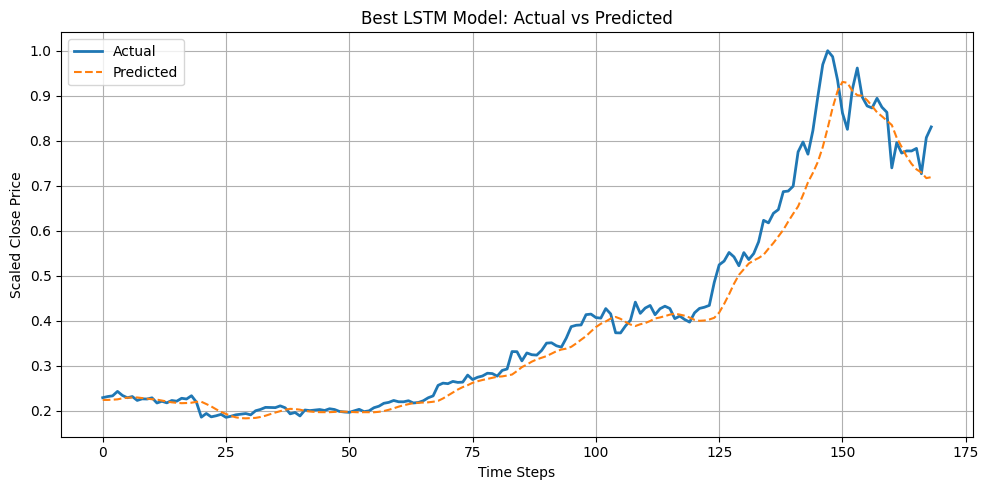

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(testY, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title("Best LSTM Model: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## RNN

In [ ]:
set_seeds(42)

param_grid = {
    'look_back': [10, 20, 30],
    'units': [50, 64],
    'dropout': [0.2, 0.3]
}

rnn_results_df = run_grid_search(train, test, param_grid, build_model_fn=build_rnn_model, model_name="RNN")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

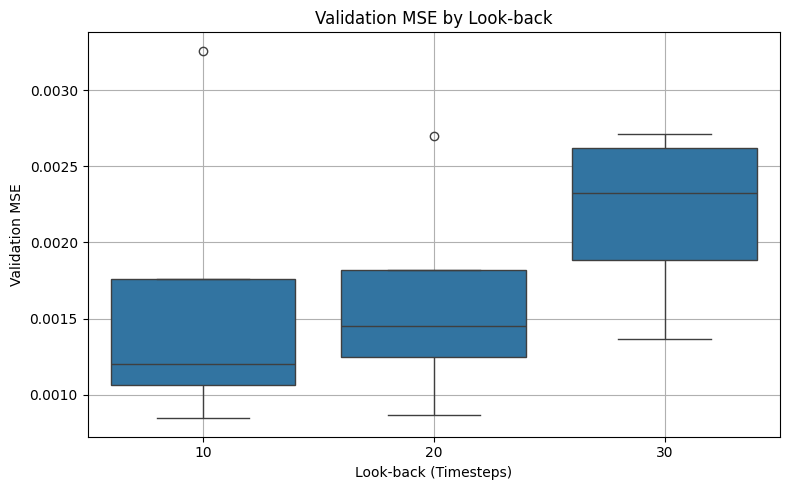

In [ ]:
rnn_results_df = rnn_results_df.sort_values(by="val_mse")
plt.figure(figsize=(8, 5))
sns.boxplot(data=rnn_results_df, x='look_back', y='val_mse')
plt.title("Validation MSE by Look-back")
plt.xlabel("Look-back (Timesteps)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

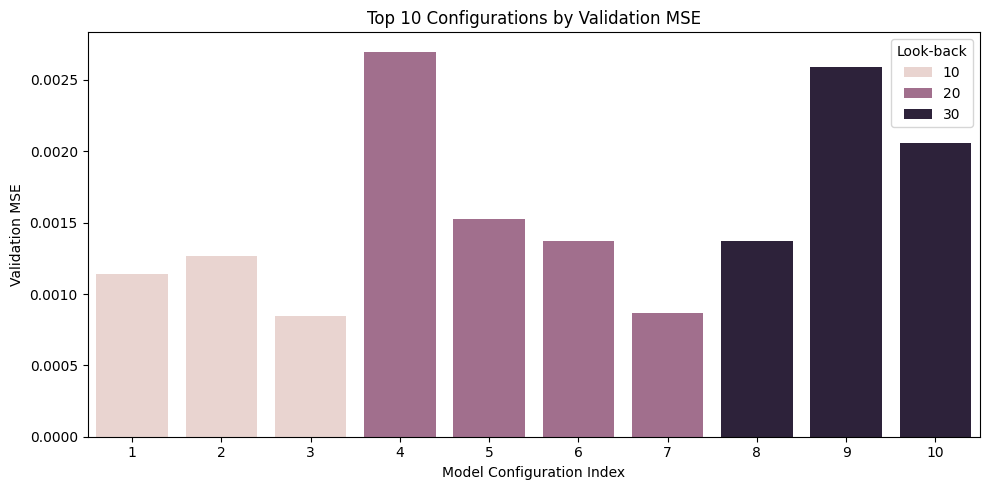

In [ ]:
top10 = rnn_results_df.sort_values("val_mse").head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x=top10.index, y='val_mse', hue='look_back')
plt.title("Top 10 Configurations by Validation MSE")
plt.xlabel("Model Configuration Index")
plt.ylabel("Validation MSE")
plt.legend(title='Look-back')
plt.tight_layout()
plt.show()

In [ ]:
best_config = rnn_results_df.sort_values(by='val_mse').iloc[0]
print("Best config:\n", best_config)

Best config:
 model             RNN
look_back          10
units              64
dropout           0.3
val_mse      0.000846
Name: 3, dtype: object


In [ ]:
# Recreate dataset for best look_back
best_look_back = int(best_config['look_back'])
trainX, trainY = create_dataset(train, best_look_back)
testX, testY = create_dataset(test, best_look_back)

trainX = reshape_for_rnn(trainX)
testX = reshape_for_rnn(testX)

In [ ]:
# Retrain the best model
best_model = build_rnn_model(
    input_shape=(best_look_back, 1),
    units=int(best_config['units']),
    dropout=float(best_config['dropout'])
)

best_model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

preds = best_model.predict(testX)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


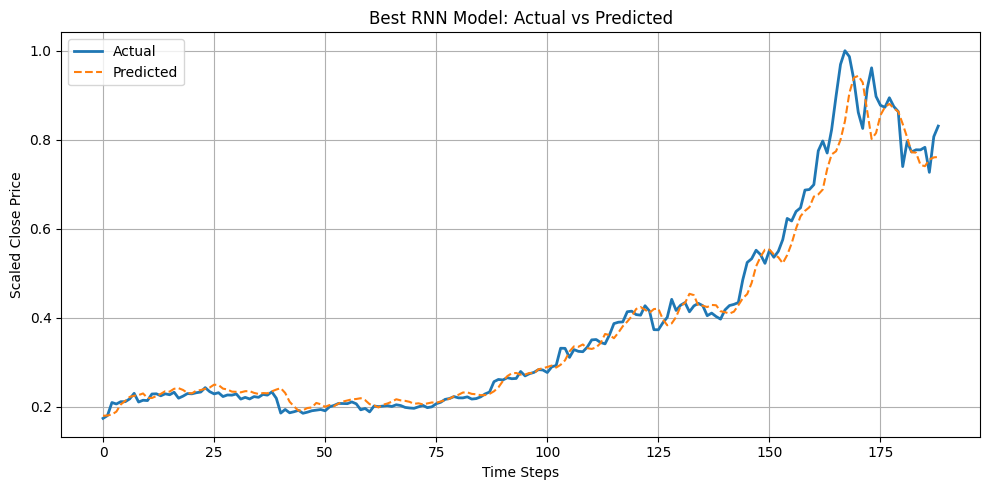

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(testY, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title("Best RNN Model: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()